# Unsupervised Learning: Clustering Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering as AC, KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score as mis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from scipy.spatial.distance import cdist
from itertools import combinations

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [2]:
class HACClustering(BaseEstimator,ClusterMixin):
    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
    def fit(self,X,y=None,normalize = True):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don’t need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        n = X.shape[0]
        m = X.shape[1]
        if normalize:
            minx = np.min(X,axis = 0)
            maxx = np.max(X,axis = 0)
            X = (X-minx)/(maxx-minx)
        D = cdist(X,X) + np.eye(n)*99
        n_clusters = n
        cur_labels = np.arange(n)
        if self.link_type == 'single':
            while n_clusters > self.k:
                try:
                    i,j = np.where(D==np.min(D))[0]
                except:
                    #print(np.where(D == np.min(D)))
                    i, j = np.where(D== np.min(D))[0][0], np.where(D == np.min(D))[1][0]
                cur_labels[cur_labels == cur_labels[j]] = cur_labels[i]
                #print(np.round(D,3))
                D[i,j] = 99
                D[j,i] = 99
                #print(cur_labels)
                n_clusters = np.unique(cur_labels).shape[0]
        else:
            while n_clusters > self.k:
                #print(n_clusters,end = ' ’)
                combos = combinations(np.unique(cur_labels),2)
                combis = []
                #print(combos)
                dists = []
                for ci, cj in combos:
                    combis.append([ci,cj])
                    ci_indices = np.where(cur_labels == ci)[0]
                    cj_indices = np.where(cur_labels == cj)[0]
                    #print(D)
                    #print(D[ci_indices,cj_indices])
                    dists.append(np.max([[D[ci_index,cj_index] for ci_index in ci_indices] for cj_index in cj_indices]))
                #print(dists)
                #print(np.argmin(dists))
                merge_i, merge_j = list(combis)[np.argmin(dists)]
                cur_labels[cur_labels == cur_labels[merge_j]] = cur_labels[merge_i]
                #print(np.round(D,3))
                #D[i,j] = 99
                #D[j,i] = 99
                #print(cur_labels)
                n_clusters = np.unique(cur_labels).shape[0]
        #print(n_clusters)
        #print(cur_labels)
        cts = np.zeros(self.k)
        sses = np.zeros(self.k)
        centroids = np.zeros((self.k,m))
        for i,l in enumerate(np.unique(cur_labels)):
            cts[i] = cur_labels[cur_labels == l].shape[0]
            centroids[i] = np.mean(X[cur_labels ==l],axis = 0)
            self.centroids = centroids
        for i,x in enumerate(X):
            l = cur_labels[i]
            ind = list(np.unique(cur_labels)).index(l)
            sses[ind] += np.linalg.norm(x-self.centroids[ind])**2
        self.cts = cts
        self.sses = sses
        #print(self.cts)
        #print(self.centroids)
        #print(self.sses)
        return self

    def print_clusters(self):
        print("Num Clusters: {:d}\n".format(self.k))
        #print("Silhouette score:{:.4f}\n".format(np.sum(self.sses)))
        i = 0
        for ct, cent in zip(self.cts, self.centroids):
            print(np.array2string(cent,precision=4,separator=","))
            print(f"{int(ct)}")
            #print("{:.4f}\n".format(self.sses[i]))
            i+=1

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [3]:
data = pd.DataFrame(arff.loadarff('abalone.arff')[0], dtype=float)
X = data.values
HAC = HACClustering(k=5)
HAC.fit(X)
model = AC(5, linkage='single')
model.fit(X)
print("Silhouette score:{:.4f}\n".format(silhouette_score(X, model.labels_)))
HAC.print_clusters()



Silhouette score:0.4813

Num Clusters: 5

[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195
[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1
[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2
[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1
[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1


In [4]:
hac = HACClustering(k = 5,link_type = 'complete')
hac.fit(X,normalize = True)
model = AC(5, linkage='complete')
model.fit(X)
print("Silhouette score:{:.4f}\n".format(silhouette_score(X, model.labels_)))
hac.print_clusters()

Silhouette score:0.5136

Num Clusters: 5

[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71
[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67
[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38
[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16
[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8


Discussion

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [5]:
data = pd.DataFrame(arff.loadarff('seismic-bumps_train.arff')[0], dtype=float)
X = data.values
hac = HACClustering(k = 5,link_type = 'complete')
hac.fit(X,normalize = True)
model = AC(5, linkage='complete')
model.fit(X)
print("Silhouette score:{:.4f}\n".format(silhouette_score(X, model.labels_)))
hac.print_clusters()

Silhouette score:0.3359

Num Clusters: 5

[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49
[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3
[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18
[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49
[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21


#### Single Link

In [6]:
HAC = HACClustering(k=5)
HAC.fit(X)
model = AC(5, linkage='single')
model.fit(X)
print("Silhouette score:{:.4f}\n".format(silhouette_score(X, model.labels_)))
HAC.print_clusters()

Silhouette score:-0.0708

Num Clusters: 5

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70


Discussion

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [7]:
class KMEANSClustering(BaseEstimator,ClusterMixin):
    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
    def fit(self,X,y=None,maxiter = 1000,normalize = True):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don’t need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        k = self.k
        m,n = X.shape
        if normalize:
            minx = np.min(X,axis = 0)
            maxx = np.max(X,axis = 0)
            X = (X-minx)/(maxx-minx)
        minx = np.min(X,axis = 0)
        maxx = np.max(X,axis = 0)
        #print(minx,maxx)
        if self.debug:
            self.centroids = X[:k]
        else:
            self.centroids = np.random.uniform(minx,maxx,(self.k,X.shape[1]))
        self.new_centroids = np.zeros_like(self.centroids)
        
        cur_labels = np.zeros((m,),dtype = int)
        cts = np.zeros(k,)
        for i in range(maxiter):
            cur_labels = self.classify(X)
            #print(cur_labels)
            #print(cur_labels)
            for j in range(k):
                if j in cur_labels:
                    self.new_centroids[j] = np.mean(X[cur_labels == j],axis = 0)
                else:
                    self.new_centroids[j] = self.centroids[j]
            for j in range(k):
                cts[j] = X[cur_labels == j].shape[0]
            sses = np.zeros((k,))
            for l,x in zip(cur_labels,X):
                sses[l] += np.linalg.norm(x-self.centroids[l])**2
            #print(sses)
            #print(centroids, new_centroids)
            #print(np.linalg.norm(self.centroids-self.new_centroids))
            if np.linalg.norm(self.centroids-self.new_centroids) < 1e-5:
                #print(f'exiting at {i+1} iters')
                self.centroids = self.centroids
                self.cts = cts
                self.sses = sses
                break
            self.centroids = self.new_centroids.copy()
        return self
    def classify(self, X):
        #print([(np.linalg.norm(row-self.centroids, axis=1)) for row in X])
        return np.array([np.argmin(np.linalg.norm(row-self.centroids, axis=1)) for row in X])
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}".format(self.k))
        #print("Silhouette Score: {:.4f}\n".format(np.sum(self.sses)))
        i = 0
        for ct, cent in zip(self.cts, self.centroids):
            print(np.array2string(cent,precision=4,separator=','))
            print(f'{int(ct)}')
            #print('{:.4f}\n'.format(self.sses[i]))
            i+=1

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [8]:
# Load debug data
data = pd.DataFrame(arff.loadarff('abalone.arff')[0], dtype=np.float)
# Train on debug data
model = KMEANSClustering(k=5, debug=True)
model.fit(data.values, normalize=True)
sil = KMeans(5)
sil.fit(data.values,)
print("Silhouette score:{:.4f}\n".format(silhouette_score(data.values, sil.labels_)))
# # Print clusters
model.print_clusters()

Silhouette score:0.5377

Num clusters: 5
[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75
[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34
[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24
[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54
[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [9]:
# Load evaluation data
data = pd.DataFrame(arff.loadarff('seismic-bumps_train.arff')[0], dtype=np.float)

# Train on evaluation data
model = KMEANSClustering(k=5, debug=True)
model.fit(data.values)
sil = KMeans(5)
sil.fit(data.values,)
print("Silhouette score:{:.4f}\n".format(silhouette_score(data.values, sil.labels_)))

# Print clusters
model.print_clusters()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Silhouette score:0.3731

Num clusters: 5
[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22
[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31
[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20
[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19
[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48


## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

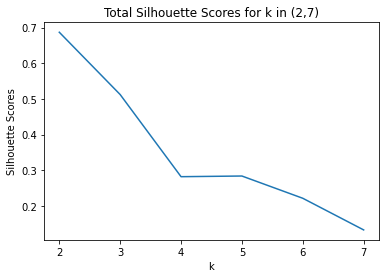

In [10]:
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']
iris_info = np.vstack((data.T,target)).T

sse = []
sil_scores = []
#print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k)
    HAC.fit(iris_info)
    model = AC(k, linkage='single')
    model.fit(data)
    sil_scores.append(silhouette_score(data,model.labels_))
    # Get data 
    #sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sil_scores)
plt.title("Total Silhouette Scores for k in (2,7)")
plt.xlabel("k")
plt.ylabel("Silhouette Scores")
plt.show()

We normalize the data


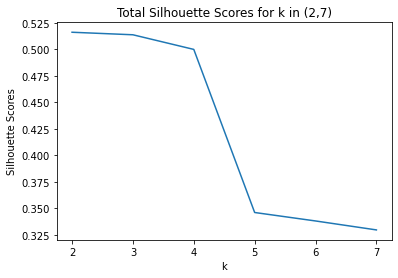

In [11]:
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

sse = []
sil_scores = []
print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k, link_type='complete')
    HAC.fit(data)
    model = AC(k, linkage='complete')
    model.fit(data)
    sil_scores.append(silhouette_score(data,model.labels_))
    # Get data 
    #sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sil_scores)
plt.title("Total Silhouette Scores for k in (2,7)")
plt.xlabel("k")
plt.ylabel("Silhouette Scores")
plt.show()

Discuss your results including the differences between single-link and complete-link

### 2.2 (10%) Iris Clustering with K-means

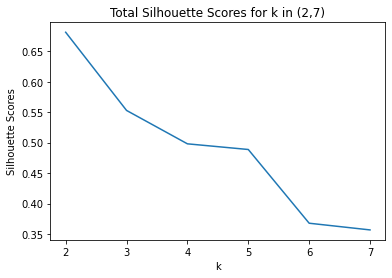

In [12]:
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

sse = []
sil_scores = []
for k in range(2,8):
    # Train
    model = KMEANSClustering(k=k, debug=True)
    model.fit(data)
    kmeans = KMeans(k)
    kmeans.fit(data)
    sil_scores.append(silhouette_score(data, kmeans.labels_))
    # Get data 
    #sse.append(np.sum(model.sses))

# Plot SSE
plt.plot(list(range(2,8)), sil_scores)
plt.title("Total Silhouette Scores for k in (2,7)")
plt.xlabel("k")
plt.ylabel("Silhouette Scores")
plt.show()

Discuss your results

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids.

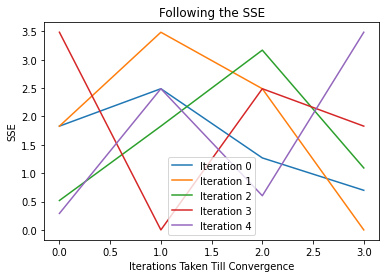

In [13]:
sses = []
for i in range(5):
    model = KMEANSClustering(k=4)
    model.fit(iris_info)
    # Get data 
    sses.append(model.sses)

for i,sse in enumerate(sses):
    plt.plot(sse, label=f'Iteration {i}')
plt.ylabel("SSE")
plt.xlabel('Iterations Taken Till Convergence')
plt.title("Following the SSE")
plt.legend()
plt.show()

Discuss any variations in the results

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just complete link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

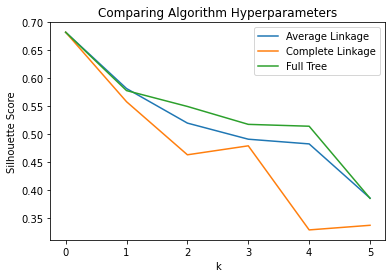

In [14]:
auto, full, elkan = [], [], []
for k in range(2,8):
    model = AC(k, linkage='average')
    model.fit(iris_info)
    auto.append(silhouette_score(iris_info, model.labels_))
    model = AC(k, linkage='complete')
    model.fit(iris_info)
    full.append(silhouette_score(iris_info, model.labels_))
    model = AC(k, compute_full_tree=True)
    model.fit(iris_info)
    elkan.append(silhouette_score(iris_info, model.labels_))
plt.plot(auto, label='Average Linkage')
plt.plot(full, label='Complete Linkage')
plt.plot(elkan, label='Full Tree')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Comparing Algorithm Hyperparameters')
plt.legend()
plt.show()

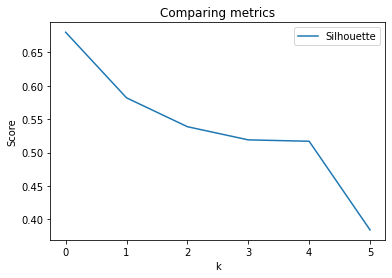

In [18]:
# Load sklearn 
sil_scores = []
#mutual_info = []
for k in range(2,8):
    model = KMeans(k)
    model.fit(iris_info)
    sil_scores.append(silhouette_score(iris_info, model.labels_))
    #mutual_info.append(mis(target, model.labels_))
plt.plot(sil_scores, label='Silhouette')
#plt.plot(mutual_info, label='Mutual Info')
plt.title("Comparing metrics")
plt.xlabel("k")
plt.ylabel('Score')
plt.legend()
plt.show()

*Discuss Results and Comparison with your versions of the algorithms. Discuss effects of different hyperparameters*

### 3.2 (10%) Run the SK version of HAC (just complete link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

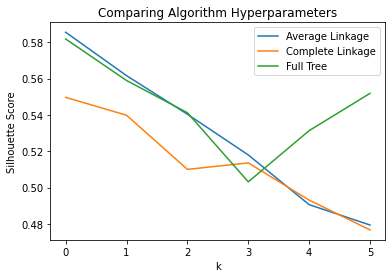

In [16]:
data = pd.DataFrame(arff.loadarff('abalone.arff')[0], dtype=float)
X = data.values
auto, full, elkan = [], [], []
for k in range(2,8):
    model = AC(k, linkage='average')
    model.fit(X)
    auto.append(silhouette_score(X, model.labels_))
    model = AC(k, linkage='complete')
    model.fit(X)
    full.append(silhouette_score(X, model.labels_))
    model = AC(k, compute_full_tree=True)
    model.fit(X)
    elkan.append(silhouette_score(X, model.labels_))
plt.plot(auto, label='Average Linkage')
plt.plot(full, label='Complete Linkage')
plt.plot(elkan, label='Full Tree')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Comparing Algorithm Hyperparameters')
plt.legend()
plt.show()

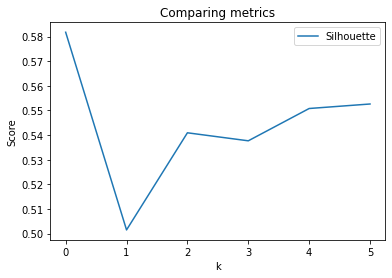

In [17]:
data = pd.DataFrame(arff.loadarff('abalone.arff')[0], dtype=float)
X = data.values
sil_scores = []
#mutual_info = []
for k in range(2,8):
    model = KMeans(k)
    model.fit(X)
    sil_scores.append(silhouette_score(X, model.labels_))
    #mutual_info.append(mis(target, model.labels_))
plt.plot(sil_scores, label='Silhouette')
#plt.plot(mutual_info, label='Mutual Info')
plt.title("Comparing metrics")
plt.xlabel("k")
plt.ylabel('Score')
plt.legend()
plt.show()

*Discussion*

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experiments. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*